## Import

In [1]:
import requests
import json
from http import HTTPStatus

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import string

import pandas as pd 

from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import bigrams

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Activity 3

## Sub-activity: Loading and pre-processing of text data

### Task1 

In [2]:
#Task 1: Create function, and returns a list of WikiData entities of humans which won the ACM Turing Award
def get_turing_award_recipients():
    
    endpoint = "https://query.wikidata.org/sparql"
    query = '''SELECT ?human ?humanLabel WHERE { 
        ?human wdt:P166 wd:Q185667.       # (P166 with Q185667 for Turing Award)
         SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en".
    }}'''

    
    api_params = {
        'query': query,
        "format" : "json"
    }
    
    response = requests.get(endpoint, params=api_params)
    
    if response.status_code >= HTTPStatus.BAD_REQUEST:
        raise RuntimeError('Request failed: {0}'.format(response.text))
        
    entities = []
    data = response.json()
    
    # Extract winner's ID, name and url
    for item in data['results']['bindings']:
        entities.append({'id' : item['human']['value'].split('/')[-1],
                        'name' : item['humanLabel']['value'],
                        'url' : item['human']['value']})
        
  
    return entities


In [3]:
#check output
entities = get_turing_award_recipients()
print(len(entities))
entities[:5]

76


[{'id': 'Q80',
  'name': 'Tim Berners-Lee',
  'url': 'http://www.wikidata.org/entity/Q80'},
 {'id': 'Q8556',
  'name': 'Edsger W. Dijkstra',
  'url': 'http://www.wikidata.org/entity/Q8556'},
 {'id': 'Q9602',
  'name': 'Frances E. Allen',
  'url': 'http://www.wikidata.org/entity/Q9602'},
 {'id': 'Q11609',
  'name': 'Shafrira Goldwasser',
  'url': 'http://www.wikidata.org/entity/Q11609'},
 {'id': 'Q17457',
  'name': 'Donald Knuth',
  'url': 'http://www.wikidata.org/entity/Q17457'}]

### Task 2

In [4]:
# Write a function, and retu
def get_wikipedia_content(search_id):
    #use id to find out name(titles)
    url = f"https://www.wikidata.org/wiki/Special:EntityData/{search_id}.json"
    response = requests.get(url)
    data = response.json()
    
    name = data['entities'][search_id]['sitelinks'].get('enwiki', {}).get('title')  
    #name = data['entities'][search_id]['labels']['en']['value']

    
    url = "https://en.wikipedia.org/w/api.php"
    params = {
        "action": "query",
        "format": "json",
        "prop": "extracts",
        "exintro": True,
        "explaintext": True, 
        "titles": name
    }

    response = requests.get(url=url, params=params)
    data = response.json()
    
    extracts = {page_id: info['extract'] for page_id, info in data['query']['pages'].items()}
    extract = next(iter(extracts.values()), None)

    return extract


In [5]:
search_id = 'Q80'
url = f"https://www.wikidata.org/wiki/Special:EntityData/{search_id}.json"
response = requests.get(url)
data = response.json()
data['entities'][search_id]['sitelinks']['afwiki']['title']

'Tim Berners-Lee'

In [6]:
content = get_wikipedia_content('Q80')
content

'Sir Timothy John Berners-Lee  (born 8 June 1955), also known as TimBL, is an English computer scientist best known as the inventor of the World Wide Web, the HTML markup language, the URL system, and HTTP. He is a professorial research fellow at the University of Oxford and a professor emeritus at the Massachusetts Institute of Technology (MIT).Berners-Lee proposed an information management system on 12 March 1989 and implemented the first successful communication between a Hypertext Transfer Protocol (HTTP) client and server via the Internet in mid-November.\nHe devised and implemented the first Web browser and Web server and helped foster the Web\'s subsequent explosive development. He is the founder and director of the World Wide Web Consortium (W3C), which oversees the continued development of the Web. He co-founded (with Rosemary Leith) the World Wide Web Foundation. In April 2009, he was elected as Foreign Associate of the National Academy of Sciences.Berners-Lee is a senior res

### Task 3

In [7]:
#Create a dictionary award winners 
award_winners = []
for i in range(len(entities)):
    wikidata_id = entities[i]['id']
    url = f"https://www.wikidata.org/w/api.php?action=wbgetentities&ids={wikidata_id}&format=json&languages=en&props=labels|descriptions|claims"

    response = requests.get(url)
    data = response.json()
    entity = data['entities'][wikidata_id]
    introduction = get_wikipedia_content(wikidata_id)
    
    # Construct the result dictionary
    result = {
        'name': entities[i]['name'],
        'intro': introduction,
        'gender': entity['claims']['P21'][0]['mainsnak']['datavalue']['value']['id'] if 'P21' in entity['claims'] else None,
        'birth_date': entity['claims']['P569'][0]['mainsnak']['datavalue']['value']['time'] if 'P569' in entity['claims'] else None,
        'birth_place': entity['claims']['P19'][0]['mainsnak']['datavalue']['value']['id'] if 'P19' in entity['claims'] else None,
        'employer': [claim['mainsnak']['datavalue']['value']['id'] for claim in entity['claims']['P108']] if 'P108' in entity['claims'] else [],
        'educated_at': [claim['mainsnak']['datavalue']['value']['id'] for claim in entity['claims']['P69']] if 'P69' in entity['claims'] else []
    }
    
    award_winners.append(result)
print(len(award_winners))
award_winners[:3]

76


[{'name': 'Tim Berners-Lee',
  'intro': 'Sir Timothy John Berners-Lee  (born 8 June 1955), also known as TimBL, is an English computer scientist best known as the inventor of the World Wide Web, the HTML markup language, the URL system, and HTTP. He is a professorial research fellow at the University of Oxford and a professor emeritus at the Massachusetts Institute of Technology (MIT).Berners-Lee proposed an information management system on 12 March 1989 and implemented the first successful communication between a Hypertext Transfer Protocol (HTTP) client and server via the Internet in mid-November.\nHe devised and implemented the first Web browser and Web server and helped foster the Web\'s subsequent explosive development. He is the founder and director of the World Wide Web Consortium (W3C), which oversees the continued development of the Web. He co-founded (with Rosemary Leith) the World Wide Web Foundation. In April 2009, he was elected as Foreign Associate of the National Academy

### Task 4

In [8]:
# Print the name of all award winners in alphabetical order.

names = []
for i in range(len(entities)):
    name = entities[i]['name']
    names.append(name)

# sort
sorted_names = sorted(names)
sorted_names

['Adi Shamir',
 'Alan Kay',
 'Alan Perlis',
 'Alfred Aho',
 'Allen Newell',
 'Amir Pnueli',
 'Andrew Yao',
 'Barbara Liskov',
 'Bob Kahn',
 'Butler Lampson',
 'Charles Bachman',
 'Charles P. Thacker',
 'Dana Scott',
 'David A. Patterson',
 'Dennis M. Ritchie',
 'Donald Knuth',
 'Douglas Engelbart',
 'E. Allen Emerson',
 'Edgar F. Codd',
 'Edmund M. Clarke',
 'Edsger W. Dijkstra',
 'Edward Feigenbaum',
 'Edwin Catmull',
 'Fernando J. Corbató',
 'Frances E. Allen',
 'Fred Brooks',
 'Geoffrey Hinton',
 'Herbert Simon',
 'Iosif Sifakis',
 'Ivan Sutherland',
 'Jack Dongarra',
 'James H. Wilkinson',
 'Jeffrey David Ullman',
 'Jim Gray',
 'John Backus',
 'John Cocke',
 'John Edward Hopcroft',
 'John L. Hennessy',
 'John McCarthy',
 'Judea Pearl',
 'Juris Hartmanis',
 'Ken Thompson',
 'Kenneth E. Iverson',
 'Kristen Nygaard',
 'Leonard Adleman',
 'Leslie Lamport',
 'Leslie Valiant',
 'Manuel Blum',
 'Martin Edward Hellman',
 'Marvin Minsky',
 'Maurice Wilkes',
 'Michael O. Rabin',
 'Michael St

### Task 5

In [9]:
#check the type
type(award_winners[1]["intro"])

str

In [10]:
#check the type
all_intros=nltk.word_tokenize(award_winners[1]["intro"])
all_intros=nltk.Text(all_intros)
type(all_intros)

nltk.text.Text

In [11]:
#Built the dataframe
nltk.download('punkt')
nltk.download('stopwords')

lt = []
stopwords = set(stopwords.words('english'))
punctuation =  set(string.punctuation)

for i in award_winners:
    intro = i["intro"]
    all_intro=nltk.word_tokenize(intro)
    all_intro=nltk.Text(all_intro)
    
    
    count_words = len(list(all_intro))
    count_sentences = len(sent_tokenize(intro))
    count_paragraphs = intro.count('\n') + 1
    fdist = nltk.FreqDist(all_intro)
    common_words = fdist.most_common(10)
    
    words_preprocessed = []
    for word in all_intro:
        if word.lower() not in stopwords and word not in punctuation:
            words_preprocessed.append(word)
    
    sdist = nltk.FreqDist(words_preprocessed)
    common_words_preprocessed = sdist.most_common(10)
    
    result = {
        'winner_name': i["name"],
        'count_words': count_words,
        'count_sentences': count_sentences,
        'count_paragraphs': count_paragraphs, 
        'common_words': [word for word, freq in common_words],
        'common_words_after_preprocessing' :[word for word, freq in common_words_preprocessed]
    }
    
    lt.append(result)

award_winners_intro = pd.DataFrame(data=lt, columns=['winner_name', 'count_words',
'count_sentences', 'count_paragraphs', 'common_words','common_words_after_preprocessing'])

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/liangyuting/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/liangyuting/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
award_winners_intro[:10]

,winner_name,count_words,count_sentences,count_paragraphs,common_words,common_words_after_preprocessing
0,Tim Berners-Lee,346,12,2,"[the, of, and, ., ,, Web, a, He, (, )]","[Web, World, Wide, MIT, first, 's, founder, Be..."
1,Edsger W. Dijkstra,341,12,2,"[the, ,, in, ., and, of, his, at, he, Dijkstra]","[Dijkstra, August, Austin, Dutch, 6, 2002, com..."
2,Frances E. Allen,81,4,1,"[,, and, the, ., was, in, to, Allen, August, 4]","[Allen, August, 4, compilers, first, woman, IB..."
3,Shafrira Goldwasser,84,2,3,"[of, the, ;, and, at, Institute, is, scientist...","[Institute, scientist, Science, Shafrira, Gold..."
4,Donald Knuth,210,9,2,"[the, of, and, ,, ., is, computer, Knuth, He, to]","[computer, Knuth, science, analysis, algorithm..."
5,Dennis M. Ritchie,120,5,1,"[the, ,, ., and, in, Ritchie, was, from, He, k...","[Ritchie, known, C, programming, language, Tho..."
6,Dana Scott,96,3,1,"[,, the, is, of, and, in, ., University, work,...","[University, work, theory, Dana, Stewart, Scot..."
7,Bob Kahn,67,2,4,"[the, ,, (, ), Kahn, with, Vint, Cerf, Protoco...","[Kahn, Vint, Cerf, Protocol, Internet, Robert,..."
8,Maurice Wilkes,83,2,1,"[the, ,, of, Wilkes, (, ), was, an, who, and]","[Wilkes, unit, Sir, Maurice, Vincent, 26, June..."
9,Alan Perlis,53,2,1,"[,, and, University, was, ., the, Alan, Jay, P...","[University, Alan, Jay, Perlis, April, 1, 1922..."


 ## Sub-activity: Applying NLP operations on the corpus

Stemming

### Task 6

In [13]:
# Stem all words with the PorterStemmer.

#First, remove stopwords and punctuation from all intros and save the remaining texts in a list named intro words.
all_intro = []
intro_words = []

for i in award_winners:
    intro = i["intro"]
    # Tokenize the current intro
    tokens = nltk.word_tokenize(intro)
    # Filter out stopwords and punctuation
    filtered_words = [word for word in tokens if word.lower() not in stopwords and word not in punctuation]
    
    intro_words.extend(filtered_words)
    all_intro.append(intro)


len(intro_words)

4726

In [14]:
#Calculate and print the number of unique words in intro words.
unique_words = set(intro_words)
print("unique words:", len(unique_words))

# Calculate and print the number of unique words, after applying the stemmer
stemmer = PorterStemmer()
stemmed_words = [stemmer.stem(word) for word in intro_words]

unique_stemmed_words = set(stemmed_words)
print("unique stemmed words after applying the PorterStemmer:", len(unique_stemmed_words))

unique words: 1817
unique stemmed words after applying the PorterStemmer: 1511


### Task 7

In [15]:
#Repeat the previous step with the SnowballStemmer
unique_words = set(intro_words)
print("unique words:", len(unique_words))

stemmer = SnowballStemmer("english")
stemmed_words = [stemmer.stem(word) for word in intro_words]

unique_stemmed_words = set(stemmed_words)
print("unique stemmed words after applying the SnowballStemmer:", len(unique_stemmed_words))

unique words: 1817
unique stemmed words after applying the SnowballStemmer: 1509


Lemmatization

### Task 8

In [16]:
#calculate the number of unique words before and after lemmatization

unique_words = set(intro_words)
print("unique words:", len(unique_words))

lemmatizer = WordNetLemmatizer()
lemmatized_words = [lemmatizer.lemmatize(word) for word in intro_words]

unique_lemmatized_words = set(stemmed_words)
print("unique stemmed words after applying the WordNetLemmatizer:", len(unique_lemmatized_words))


unique words: 1817
unique stemmed words after applying the WordNetLemmatizer: 1509


### Task 9

In [17]:
#find synonyms and antonyms from column 'common_words_after_preprocessing'

nltk.download('wordnet')

# Define the function to find synonyms
def get_synonyms(word_list):
    synonyms = []
    for word in word_list:
        for syn in wordnet.synsets(word):
            for lemma in syn.lemmas():
                synonyms.append(lemma.name())
    return list(synonyms)

# Define the function to find antonyms
def get_antonyms(word_list):
    antonyms = []
    for word in word_list:
        for syn in wordnet.synsets(word):
            for lemma in syn.lemmas():
                if lemma.antonyms():
                    antonyms.append(lemma.antonyms()[0].name())
    return list(antonyms)

award_winners_intro['synonyms'] = award_winners_intro['common_words_after_preprocessing'].apply(get_synonyms)
award_winners_intro['antonyms'] = award_winners_intro['common_words_after_preprocessing'].apply(get_antonyms)

#Print the first ten rows of the dataframe.
award_winners_intro[:10]

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/liangyuting/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,winner_name,count_words,count_sentences,count_paragraphs,common_words,common_words_after_preprocessing,synonyms,antonyms
0,Tim Berners-Lee,346,12,2,"[the, of, and, ., ,, Web, a, He, (, )]","[Web, World, Wide, MIT, first, 's, founder, Be...","[web, web, entanglement, vane, web, network, w...","[narrow, narrow, middle, last, second, ignore,..."
1,Edsger W. Dijkstra,341,12,2,"[the, ,, in, ., and, of, his, at, he, Dijkstra]","[Dijkstra, August, Austin, Dutch, 6, 2002, com...","[August, Aug, august, grand, lordly, august, r...",[]
2,Frances E. Allen,81,4,1,"[,, and, the, ., was, in, to, Allen, August, 4]","[Allen, August, 4, compilers, first, woman, IB...","[Allen, Gracie_Allen, Grace_Ethel_Cecile_Rosal...","[middle, last, second, man, man]"
3,Shafrira Goldwasser,84,2,3,"[of, the, ;, and, at, Institute, is, scientist...","[Institute, scientist, Science, Shafrira, Gold...","[institute, establish, found, plant, constitut...",[unborn]
4,Donald Knuth,210,9,2,"[the, of, and, ,, ., is, computer, Knuth, He, to]","[computer, Knuth, science, analysis, algorithm...","[computer, computing_machine, computing_device...","[synthesis, undesigned]"
5,Dennis M. Ritchie,120,5,1,"[the, ,, ., and, in, Ritchie, was, from, He, k...","[Ritchie, known, C, programming, language, Tho...","[know, cognize, cognise, know, know, know, kno...","[ignore, unknown]"
6,Dana Scott,96,3,1,"[,, the, is, of, and, in, ., University, work,...","[University, work, theory, Dana, Stewart, Scot...","[university, university, university, work, wor...","[idle, malfunction, unborn]"
7,Bob Kahn,67,2,4,"[the, ,, (, ), Kahn, with, Vint, Cerf, Protoco...","[Kahn, Vint, Cerf, Protocol, Internet, Robert,...","[Kahn, Louis_Isadore_Kahn, protocol, communica...",[unborn]
8,Maurice Wilkes,83,2,1,"[the, ,, of, Wilkes, (, ), was, an, who, and]","[Wilkes, unit, Sir, Maurice, Vincent, 26, June...","[Wilkes, John_Wilkes, Wilkes, Charles_Wilkes, ...",[]
9,Alan Perlis,53,2,1,"[,, and, University, was, ., the, Alan, Jay, P...","[University, Alan, Jay, Perlis, April, 1, 1922...","[university, university, university, Jay, John...",[]


### Task 10

In [18]:
# tokenize the intro texts you find in award winners.
for i in award_winners:
    intro = i["intro"]
    # Tokenize the current intro
    tokens = nltk.word_tokenize(intro)
    # Store the tokens back in the dictionary
    #award_winners['intro_tokens'] = tokens


### Task 11

In [19]:

def get_bigrams_frequency(intros):
    bigram_freq = {}
    
    for intro in intros:
            #Tokenize the current intro
        intro_lower = intro.lower()
        tokens = nltk.word_tokenize(intro_lower)
            # not contain any punction tokens and stopwords
        filtered_words = [word.lower() for word in tokens if word.lower() not in stopwords and word not in punctuation]
                #build bigrams
        intro_bigrams = list(bigrams(filtered_words))
        
        # cumulate
        for i in intro_bigrams:
            if i in bigram_freq:
                bigram_freq[i] += 1
            else:
                bigram_freq[i] = 1
        
    return bigram_freq

### Task 12

In [20]:
intros = []
for winner in award_winners:
    intros.append(winner['intro'])
    
winners_bigrams = get_bigrams_frequency(intros)

### Task 13

In [21]:
sorted_winners_bigrams = sorted(winners_bigrams.items(), key=lambda item: item[1], reverse=True)

#print 15 most frequently
sorted_winners_bigrams[:15]

[(('turing', 'award'), 62),
 (('computer', 'scientist'), 60),
 (('computer', 'science'), 51),
 (('american', 'computer'), 32),
 (('artificial', 'intelligence'), 15),
 (('programming', 'language'), 14),
 (('best', 'known'), 12),
 (('national', 'academy'), 10),
 (('programming', 'languages'), 10),
 (('received', 'turing'), 10),
 (('professor', 'computer'), 9),
 (('carnegie', 'mellon'), 8),
 (('academy', 'engineering'), 8),
 (('deep', 'learning'), 8),
 (('massachusetts', 'institute'), 7)]

## Sub-section: Visualisation

Barplots:

### Task 14

In [22]:
award_winners_intro[:3]

,winner_name,count_words,count_sentences,count_paragraphs,common_words,common_words_after_preprocessing,synonyms,antonyms
0,Tim Berners-Lee,346,12,2,"[the, of, and, ., ,, Web, a, He, (, )]","[Web, World, Wide, MIT, first, 's, founder, Be...","[web, web, entanglement, vane, web, network, w...","[narrow, narrow, middle, last, second, ignore,..."
1,Edsger W. Dijkstra,341,12,2,"[the, ,, in, ., and, of, his, at, he, Dijkstra]","[Dijkstra, August, Austin, Dutch, 6, 2002, com...","[August, Aug, august, grand, lordly, august, r...",[]
2,Frances E. Allen,81,4,1,"[,, and, the, ., was, in, to, Allen, August, 4]","[Allen, August, 4, compilers, first, woman, IB...","[Allen, Gracie_Allen, Grace_Ethel_Cecile_Rosal...","[middle, last, second, man, man]"


Text(0, 0.5, 'Number of Words')

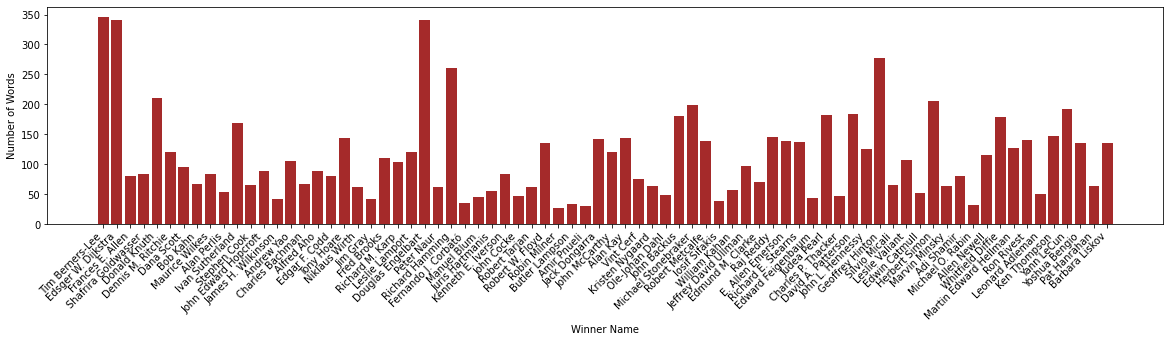

In [23]:
# number of words (1st plot),
plt.figure(figsize=(20, 4))
plt.bar(award_winners_intro['winner_name'], award_winners_intro['count_words'], color='brown')
plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels
plt.xlabel('Winner Name')
plt.ylabel('Number of Words')

Text(0, 0.5, 'Number of Sentences')

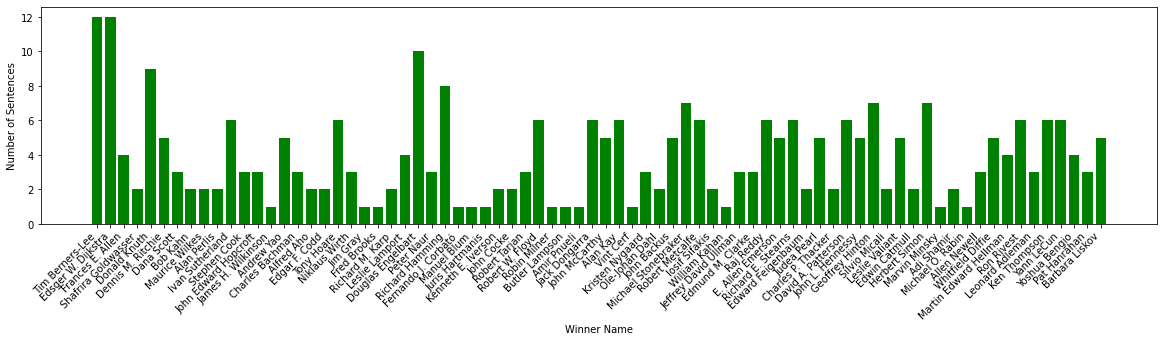

In [24]:
# number of sentences (2st plot),
plt.figure(figsize=(20, 4))
plt.bar(award_winners_intro['winner_name'], award_winners_intro['count_sentences'], color='green')
plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels
plt.xlabel('Winner Name')
plt.ylabel('Number of Sentences')

Text(0, 0.5, 'Number of Paragraphs')

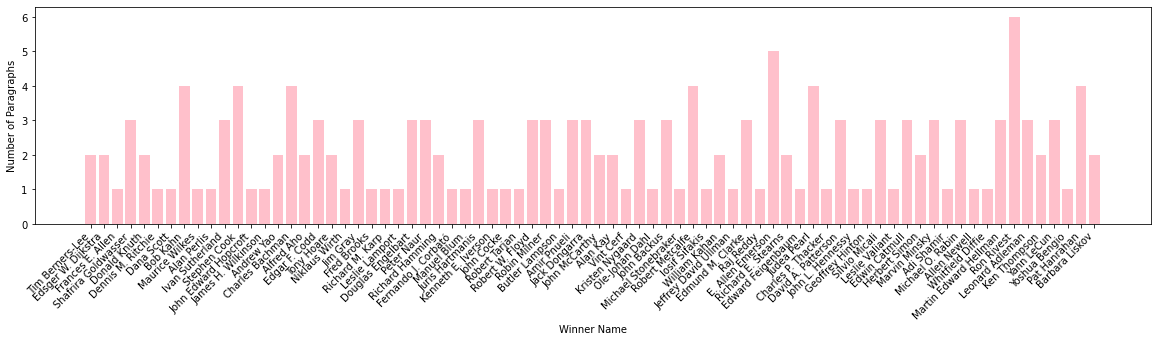

In [25]:
# number of paragraphs (3st plot),
plt.figure(figsize=(20, 4))
plt.bar(award_winners_intro['winner_name'], award_winners_intro['count_paragraphs'], color='pink')
plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels
plt.xlabel('Winner Name')
plt.ylabel('Number of Paragraphs')

### Task 15

Text(0, 0.5, 'Number of Paragraphs')

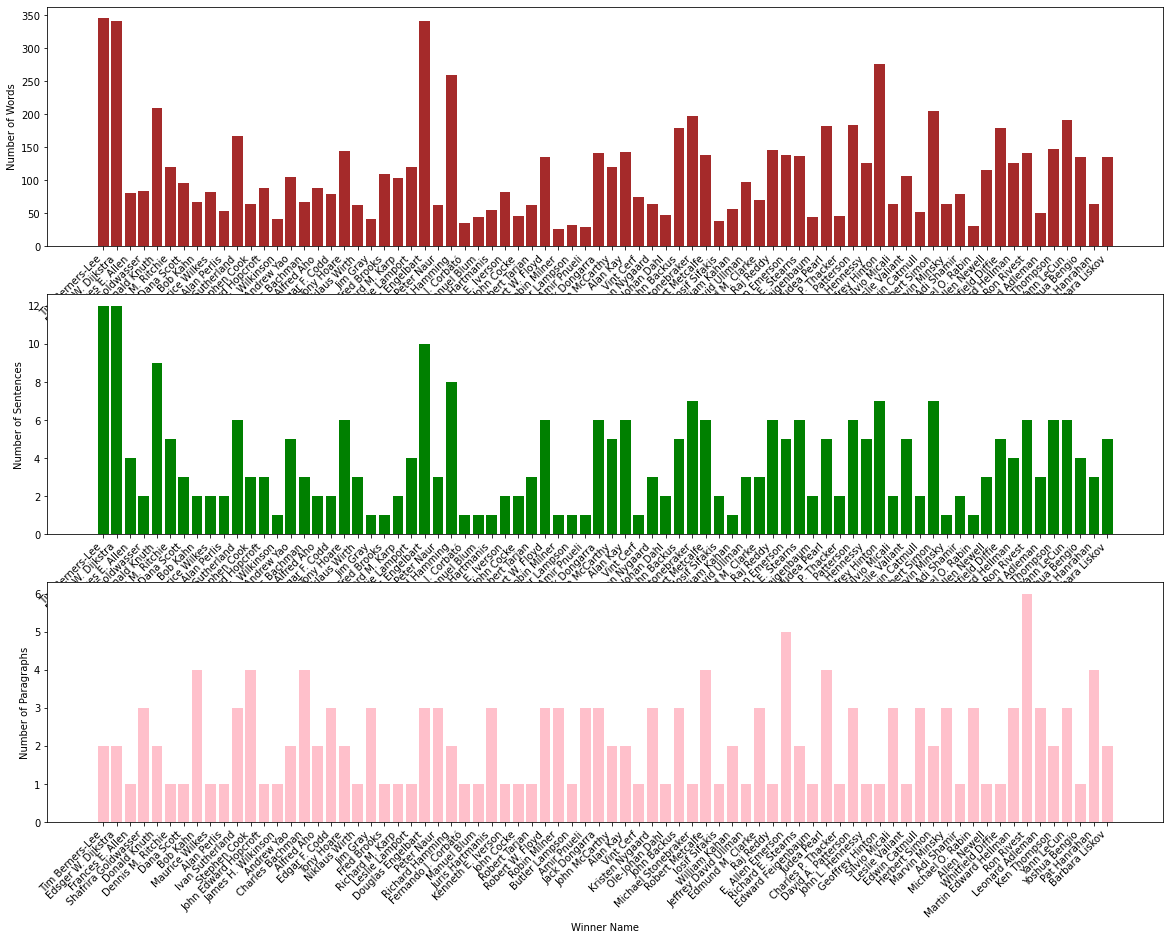

In [26]:
plt.figure(figsize=(20, 15))

# number of words (1st plot),
plt.subplot(3, 1, 1)
plt.bar(award_winners_intro['winner_name'], award_winners_intro['count_words'], color='brown')
plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels
plt.xlabel('Winner Name')
plt.ylabel('Number of Words')

# number of sentences (2st plot),
plt.subplot(3, 1, 2)
plt.bar(award_winners_intro['winner_name'], award_winners_intro['count_sentences'], color='green')
plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels
plt.xlabel('Winner Name')
plt.ylabel('Number of Sentences')

# number of paragraphs (3st plot),
plt.subplot(3, 1, 3)
plt.bar(award_winners_intro['winner_name'], award_winners_intro['count_paragraphs'], color='pink')
plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels
plt.xlabel('Winner Name')
plt.ylabel('Number of Paragraphs')

### Task 16

Text(0, 0.5, 'Number of Paragraphs')

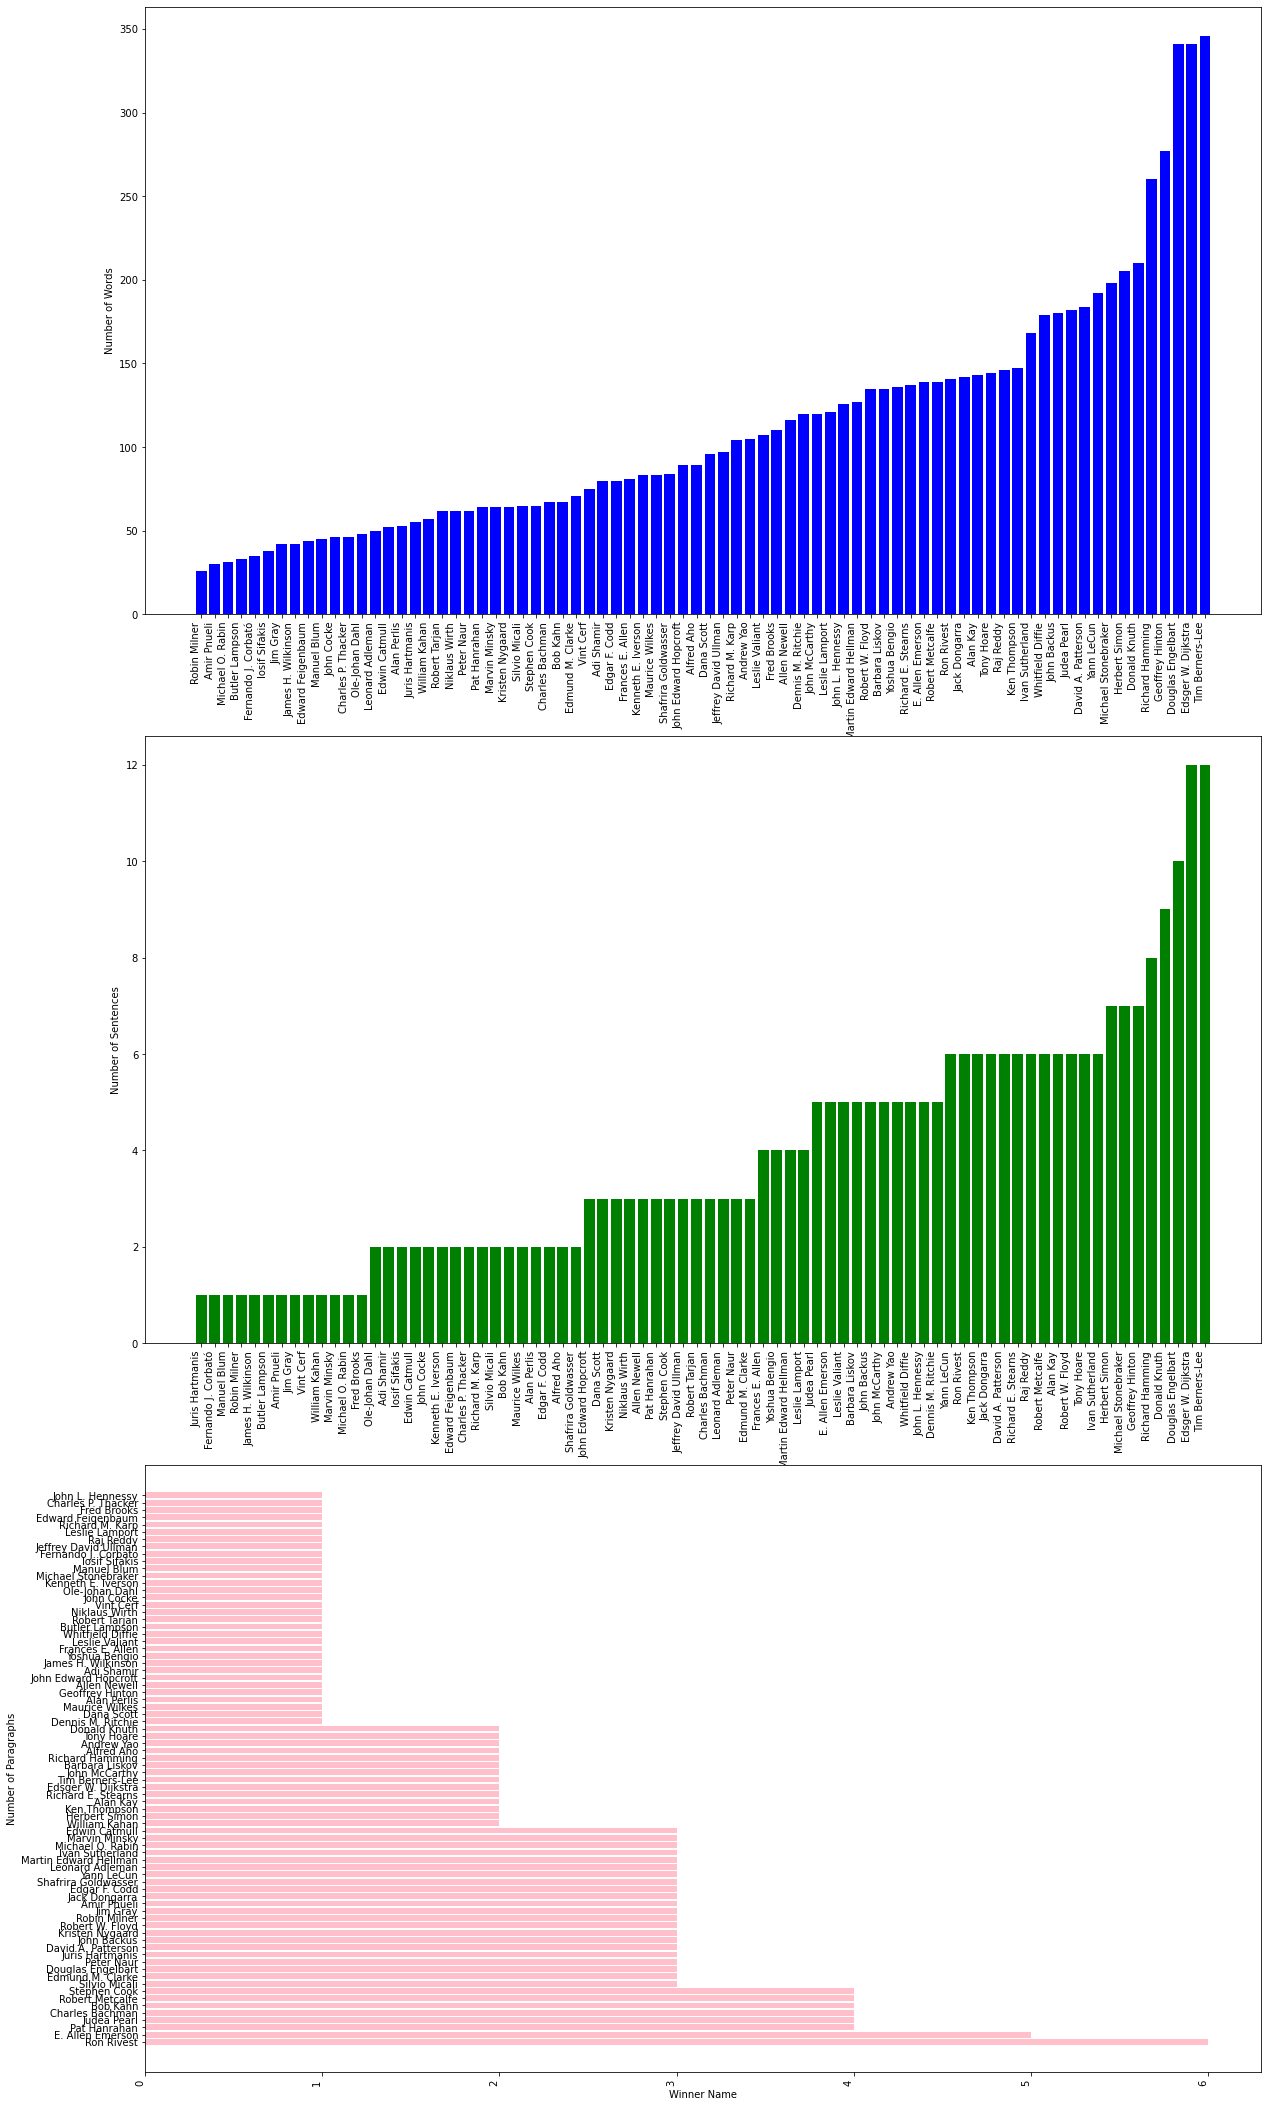

In [27]:

#--Order the bars for each plot in ascending order
sorted_data_words = award_winners_intro.sort_values('count_words')
sorted_data_sentences = award_winners_intro.sort_values('count_sentences')
#-- #Sort the horizontal bars in ascending order from top to bottom. 
sorted_data_paragraphs = award_winners_intro.sort_values('count_paragraphs', ascending=False)


plt.figure(figsize=(20, 38))

# number of words (1st plot),
plt.subplot(3, 1, 1)
# ---Change the color of the bars for the 1st barplot.
plt.bar(sorted_data_words['winner_name'], sorted_data_words['count_words'], color='blue')
plt.xticks(rotation=90, ha='right')  # ---Adjust x-axes labels for all barplots by rotating them by 90 degrees clockwise.
plt.xlabel('Winner Name')
plt.ylabel('Number of Words')

# number of sentences (2st plot),
plt.subplot(3, 1, 2)
plt.bar(sorted_data_sentences['winner_name'], sorted_data_sentences['count_sentences'], color='green')
plt.xticks(rotation=90, ha='right')  # Rotate the x-axis labels
plt.xlabel('Winner Name')
plt.ylabel('Number of Sentences')

# number of paragraphs (3st plot),
plt.subplot(3, 1, 3)
#--Replace the 3rd barplot by a horizontal barplot with the names displayed on the y- axis. 
plt.barh(sorted_data_paragraphs['winner_name'], sorted_data_paragraphs['count_paragraphs'], color='pink')
plt.xticks(rotation=90, ha='right')  # Rotate the x-axis labels
plt.xlabel('Winner Name')
plt.ylabel('Number of Paragraphs')

Heatmap:

### Task 17

In [28]:
bigrams_by_person = {}

# Iterate over the award_winners list
for person in award_winners:
    name = person['name']
    intro = person['intro']
    # Use the get_bigrams_frequency function to get bigrams for each intro
    person_bigrams = get_bigrams_frequency([intro])
    # Store the results in the bigrams_by_person dictionary
    bigrams_by_person[name] = person_bigrams
    

Text(159.0, 0.5, 'Winners')

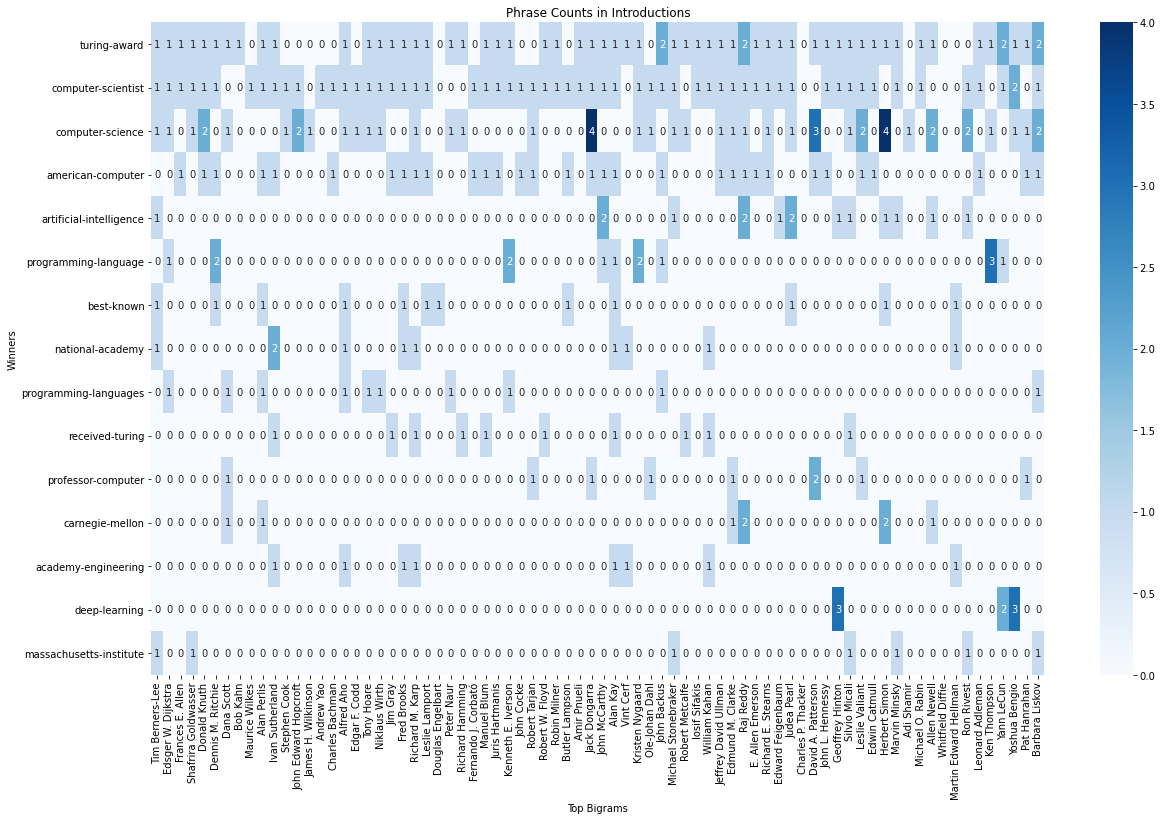

In [33]:

top_bigrams = sorted_winners_bigrams[:15]
specific_bigrams = [pair[0] for pair in top_bigrams]

# Initialize an empty dictionary to hold frequencies for the heatmap
heatmap_data = {bigram: [] for bigram in specific_bigrams}
names = []

# Populate the heatmap data with frequencies of specific bigrams for each person
for person, bigrams in bigrams_by_person.items():
    names.append(person)  # Keep track of the person names for the y-axis labels
    for bigram in specific_bigrams:
        # Add the frequency of the bigram for this person, or 0 if not present
        heatmap_data[bigram].append(bigrams.get(bigram, 0))

# Convert the dictionary to a DataFrame
df_heatmap = pd.DataFrame(heatmap_data, index=names).T

plt.figure(figsize=(20, 12))  
sns.heatmap(df_heatmap, cmap='Blues', annot=True)
plt.title('Phrase Counts in Introductions')
plt.xlabel('Top Bigrams')
plt.ylabel('Winners')